# Integrating Sphere Calculations Workbook

This workbook uses functions to calculate the relative flux observed by a detector at a specified position from an integrating sphere port. These functions are useful for calculating the nonuniformity that should be expected across a sensor illuminated by an ideal integrating sphere port and for correcting the photon flux measured by a photodiode that is not exactly at the same position as the sensor relative to the sphere port. The functions themselves are defined in the python file integrating_sphere_funcs.py

Import Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from integrating_sphere_funcs import max_sphere_nonuniformity, sphere_flux_correction, sphere_prnu

Testing that the code works and comparing measured and theoretical nonuniformity. I have two sets of data, one where the detector is at r=8D=32" and one where the detector is very close to the integrating sphere port. I measured PD reading vs. micrometer position, then fit those readings to find the point of peak intensity. I then found the radial distance from this maximum to plot relative intensity vs. d/D.

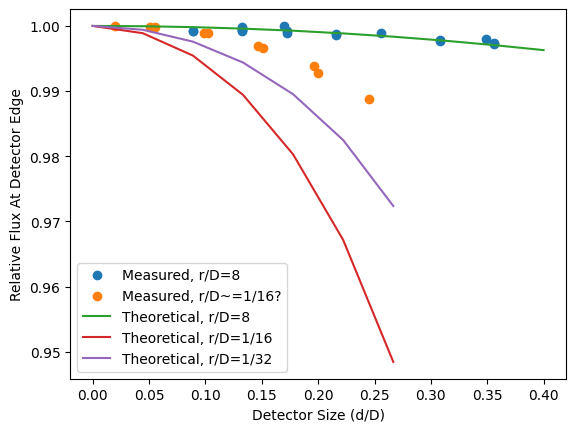

In [2]:
# I fit the data to a 2D Gaussian to find the peak position
peak_pos_far = np.array([35, 59])
pos_intensity_far = np.array([[0, 50, 3.5331E-10],
                                [5, 50, 3.5348E-10],
                                [15, 50, 3.5370E-10],
                                [25, 50, 3.5414E-10],
                                [35, 50, 3.5396E-10],
                                [45, 50, 3.5401E-10],
                                [50, 50, 3.5394E-10],
                                [0, 50, 3.5323E-10],
                                [5, 50, 3.5342E-10],
                                [15, 50, 3.5377E-10],
                                [25, 50, 3.5401E-10],
                                [35, 50, 3.5392E-10],
                                [45, 50, 3.5397E-10],
                                [50, 50, 3.5381E-10],
                                [25, 25, 3.5351E-10],
                                [25, 35, 3.5384E-10],
                                [25, 45, 3.5422E-10],
                                [25, 50, 3.5413E-10]])
peak_pos_near = np.array([25.2, 48.0])
pos_intensity_near = np.array([[5, 50, 7.2976E-8],
                                [10, 50, 7.3251E-8],
                                [15, 50, 7.3428E-8],
                                [20, 50, 7.3496E-8],
                                [25, 50, 7.3505E-8],
                                [30, 50, 7.3497E-8],
                                [35, 50, 7.3424E-8],
                                [40, 50, 7.3282E-8],
                                [45, 50, 7.3052E-8],
                                [50, 50, 7.2676E-8],])
# For each position, find the radial distance from the peak
radial_distances_near = np.zeros(len(pos_intensity_near))
for i, pos_intensity in enumerate(pos_intensity_near):
    radial_distances_near[i] = np.sqrt((pos_intensity[0] - peak_pos_near[0]) ** 2 + (pos_intensity[1] - peak_pos_near[1]) ** 2)
relative_intensities = pos_intensity_near[:, 2] / np.max(pos_intensity_near[:, 2])
radial_distances_far = np.zeros(len(pos_intensity_far))
for i, pos_intensity in enumerate(pos_intensity_far):
    radial_distances_far[i] = np.sqrt((pos_intensity[0] - peak_pos_far[0]) ** 2 + (pos_intensity[1] - peak_pos_far[1]) ** 2)
relative_intensities_far = pos_intensity_far[:, 2] / np.max(pos_intensity_far[:, 2])
# Convert to inches and divide by D
radial_distances_near = radial_distances_near / 25.4 / 4
radial_distances_far = radial_distances_far / 25.4 / 4

theory_r = np.linspace(0, 0.4, 10)
theory_intensity_far = np.zeros_like(theory_r)
theory_intensity_mid = np.zeros_like(theory_r)
theory_intensity_near = np.zeros_like(theory_r)

for i, r in enumerate(theory_r):
    theory_intensity_far[i] = max_sphere_nonuniformity(4, 8 * r, 32)
    theory_intensity_mid[i] = max_sphere_nonuniformity(4, 8 * r, 0.25)
    theory_intensity_near[i] = max_sphere_nonuniformity(4, 8 * r, 0.125)

plt.plot(radial_distances_far, relative_intensities_far, 'o', label='Measured, r/D=8')
plt.plot(radial_distances_near, relative_intensities, 'o', label='Measured, r/D~=1/16?')
plt.plot(theory_r, theory_intensity_far, label='Theoretical, r/D=8')
plt.plot(theory_r[:7], theory_intensity_mid[:7], label='Theoretical, r/D=1/16')
plt.plot(theory_r[:7], theory_intensity_near[:7], label='Theoretical, r/D=1/32')
plt.xlabel('Detector Size (d/D)')
plt.ylabel('Relative Flux At Detector Edge')
plt.legend()
plt.show()
# The points measured near the sphere are not well fit by the theoretical values for r/D >~ 1/32.
# It's hard to measure what's the real distance from the sphere to this very nearby point, since
# I'm not sure whether to treat the port as a flat surface or a curved one. So I'm not sure what
# r/D really is for these points.

In [3]:
# Example calculations, using data for COSMOS camera
sphere_D = 4
sensor_width = 3.19
hamamatsu_PD_dist = 32.0 - 0.236 # axial distance from port, in inches
hamamatsu_PD_height = 2 # radial distance from port, in inches
sensor_dist_hamamatsu = 32.0 + 1 + 0.75 + 0.67 # axial distance from port, in inches.
sensor_height_hamamatsu = 0
thorlabs_PD_dist = 32.0
thorlabs_PD_height = 1.5 # radial distance from port, in inches
sensor_dist_thorlabs = 32.0 + 5/16 + 0.67 # axial distance from port, in inches.
# 5/16 accounts for distance from end of baffle/PD to sensor; 0.67 accounts from window to sensor
sensor_height_thorlabs = 0
print(sphere_flux_correction(sphere_D, hamamatsu_PD_dist, hamamatsu_PD_height, sensor_dist_hamamatsu, sensor_height_hamamatsu, sensor_width))
print(sphere_flux_correction(sphere_D, thorlabs_PD_dist, thorlabs_PD_height, sensor_dist_thorlabs, sensor_height_thorlabs, sensor_width))

0.8547862580157854
0.9419032549956546


In [4]:
# Calculations for IMX487 in vacuum chamber
sphere_to_window = 2 # this is an estimate
window_to_pd = 4 # this is an estimate
imx487_diag = 0.437
pd_dist = window_to_pd + sphere_to_window
sensor_dist = pd_dist + 0.827
pd_height = 0.75
sensor_height = 0.75
print(max_sphere_nonuniformity(4, 2, 6))
print(sphere_flux_correction(4, pd_dist, pd_height, sensor_dist, sensor_height, imx487_diag / np.sqrt(2)))

0.9659244491704242
0.7863648578800498


In [6]:
100 * sphere_prnu(4, 1, 1, 32, sensor_width, 21)

0.43022998604528945